# Timing results from "one iteration" experiments

This notebook gathers timing from the experiments run using the [test_one_iteration.sl](../slurm/test_one_iteration.sl) script.

In [1]:
from subprocess import run
from io import StringIO

import numpy as np
import scipy.optimize as opt
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

sb.set()

In [2]:
jobs = [
    22350693,
    22360794,
    22405397,
    22456215,
    22840794,
    22842283,
    22842934,
    22843586,
    22846021,
    22846873,
    23038192,
]

Note:
- jobs 22350693, 22360794, 22405397 and 22456215 used `client.submit` to distribute `y` data,
- jobs 22840794, 22842283, 22842934, 22843586, 22846021 and 22846873 used `client.scatter` to distributed `y` data,
- job 23038192 used the new internal API (with `DaskFunctionOperator`)

In [3]:
def load_job_data(job):
    dset = pd.read_csv(f"../results/{job}-test_one_iteration.sl/n_workers.csv")
    return dset.assign(JobID=job).query("n_workers > 0")


nworkers = pd.concat([load_job_data(job) for job in jobs])
nworkers.index = range(len(nworkers))
nworkers

,date,n_workers,JobID
0,2021-09-20 06:03:46.517693,3,22350693
1,2021-09-20 06:03:56.531094,51,22350693
2,2021-09-20 06:04:06.545620,84,22350693
3,2021-09-20 06:04:17.169998,84,22350693
4,2021-09-20 06:04:28.608806,84,22350693
...,...,...,...
9665,2021-11-01 11:30:11.912528,484,23038192
9666,2021-11-01 11:30:21.938434,484,23038192
9667,2021-11-01 11:30:31.953880,483,23038192
9668,2021-11-01 11:30:41.968378,482,23038192


In [4]:
def get_job_infos(job):
    proc = run(["sacct", "-j", f"{job}"], capture_output=True)
    job_infos = pd.read_fwf(StringIO(proc.stdout.decode()))
    job_infos = job_infos[job_infos.JobID == str(job)].astype({"JobID": int})
    job_infos["Elapsed"] = pd.to_timedelta(job_infos["Elapsed"])
    return job_infos


jobs_infos = pd.concat([get_job_infos(job) for job in jobs])
jobs_infos

,JobID,JobName,Alloc,Elapsed,TotalCPU,ReqMem,MaxRSS,State
1,22350693,test_one_iterat+,8,0 days 01:47:50,36:52.801,16Gn,NaN,COMPLETED
1,22360794,test_one_iterat+,8,0 days 02:58:09,01:53:35,16Gn,NaN,COMPLETED
1,22405397,test_one_iterat+,8,0 days 02:57:01,42:00.806,16Gn,NaN,COMPLETED
1,22456215,test_one_iterat+,8,0 days 05:57:36,01:20:07,16Gn,NaN,COMPLETED
1,22840794,test_one_iterat+,8,0 days 02:01:46,45:39.545,16Gn,NaN,COMPLETED
1,22842283,test_one_iterat+,8,0 days 01:02:08,20:04.679,16Gn,NaN,COMPLETED
1,22842934,test_one_iterat+,8,0 days 01:06:50,31:43.836,16Gn,NaN,COMPLETED
1,22843586,test_one_iterat+,8,0 days 01:17:01,23:37.303,16Gn,NaN,COMPLETED
1,22846021,test_one_iterat+,8,0 days 01:54:40,38:06.707,16Gn,NaN,COMPLETED
1,22846873,test_one_iterat+,8,0 days 03:55:10,01:37:00,16Gn,NaN,COMPLETED


In [5]:
jobs_infos = (
    jobs_infos.set_index("JobID")
    .join(nworkers.groupby("JobID").mean("n_workers"))
    .assign(time_min=lambda df: df.Elapsed.dt.total_seconds() / 60)
    .sort_values(by="n_workers")
)
jobs_infos

,JobName,Alloc,Elapsed,TotalCPU,ReqMem,MaxRSS,State,n_workers,time_min
JobID,,,,,,,,,
22456215,test_one_iterat+,8,0 days 05:57:36,01:20:07,16Gn,NaN,COMPLETED,92.336620,357.600000
22846873,test_one_iterat+,8,0 days 03:55:10,01:37:00,16Gn,NaN,COMPLETED,145.333094,235.166667
22405397,test_one_iterat+,8,0 days 02:57:01,42:00.806,16Gn,NaN,COMPLETED,179.487106,177.016667
23038192,test_one_iterat+,8,0 days 02:22:42,57:12.252,16Gn,NaN,COMPLETED,252.331748,142.700000
22846021,test_one_iterat+,8,0 days 01:54:40,38:06.707,16Gn,NaN,COMPLETED,325.222883,114.666667
22350693,test_one_iterat+,8,0 days 01:47:50,36:52.801,16Gn,NaN,COMPLETED,326.900158,107.833333
22843586,test_one_iterat+,8,0 days 01:17:01,23:37.303,16Gn,NaN,COMPLETED,484.973568,77.016667
22840794,test_one_iterat+,8,0 days 02:01:46,45:39.545,16Gn,NaN,COMPLETED,495.825175,121.766667
22842934,test_one_iterat+,8,0 days 01:06:50,31:43.836,16Gn,NaN,COMPLETED,555.466495,66.833333


In [6]:
def time_curve(x, alpha, offset):
    return alpha / x + offset


(alpha, offset), _ = opt.curve_fit(
    time_curve, jobs_infos.n_workers, jobs_infos.time_min, method="trf", loss="soft_l1"
)

print(f"alpha = {alpha}, offset = {offset}")

alpha = 31688.589210922324, offset = 14.745872165717758


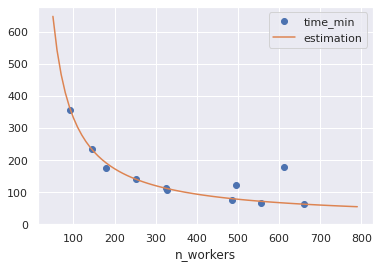

In [7]:
ax = jobs_infos.plot(x="n_workers", y="time_min", style="o")

xs = np.arange(50, 800, 10)
ax.plot(xs, time_curve(xs, alpha, offset), label="estimation")
ax.legend()

_ = ax.set_ylim(bottom=0)

In [8]:
nworkers["date"] = pd.to_datetime(nworkers.date)
nworkers["elapsed"] = nworkers.groupby("JobID")["date"].transform(
    lambda x: (x - x.min()).dt.total_seconds()
)

In [9]:
nworkers

,date,n_workers,JobID,elapsed
0,2021-09-20 06:03:46.517693,3,22350693,0.000000
1,2021-09-20 06:03:56.531094,51,22350693,10.013401
2,2021-09-20 06:04:06.545620,84,22350693,20.027927
3,2021-09-20 06:04:17.169998,84,22350693,30.652305
4,2021-09-20 06:04:28.608806,84,22350693,42.091113
...,...,...,...,...
9665,2021-11-01 11:30:11.912528,484,23038192,8388.216683
9666,2021-11-01 11:30:21.938434,484,23038192,8398.242589
9667,2021-11-01 11:30:31.953880,483,23038192,8408.258035
9668,2021-11-01 11:30:41.968378,482,23038192,8418.272533


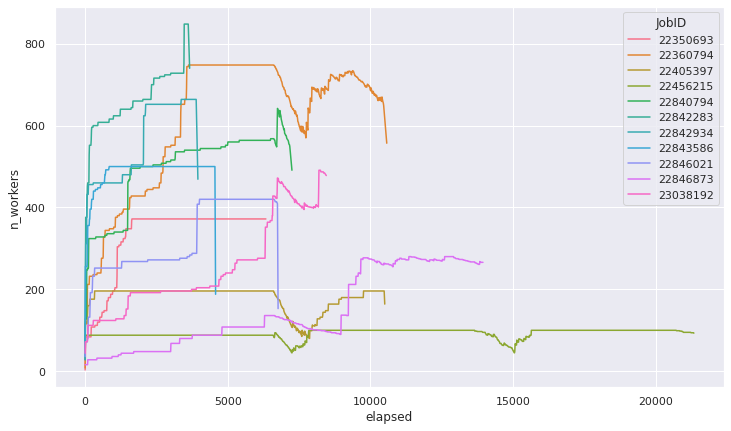

In [10]:
plt.figure(figsize=(12, 7))
_ = sb.lineplot(
    x="elapsed", y="n_workers", hue="JobID", data=nworkers.astype({"JobID": str})
)